### This script should run in seaCell environment

In [1]:
from matplotlib import pyplot as plt
from pyppca import ppca
from sklearn import mixture
from sklearn.cluster import SpectralClustering
from operator import itemgetter
import os
from sklearn.decomposition import PCA
import numpy as np
import pickle
import sys
import pandas as pd
import scanpy as sc
from sklearn.metrics import *
data_folder_path = '../../../data'
sys.path.append(data_folder_path)
import matplotlib.patches as mpatches
import anndata as ad
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import gpflow
float_type = gpflow.default_float()
import gpflux
from gpflow.config import default_float
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import muon as mu
from muon import atac as ac
from muon import prot as pt
sys.path.append('../../../mogp_decomposition/')
import mwgp as mwgp
from mwgp import GPD
import glob
from evaluation import *
from GRM import *
import seaborn as sns

def get_free_gpu_idx():
    """Get the index of the GPU with current lowest memory usage."""
    os.system("nvidia-smi -q -d Memory |grep -A4 GPU|grep Used >tmp")
    memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
    return np.argmin(memory_available)

gpu_idx = get_free_gpu_idx()
print("Using GPU #%s" % gpu_idx)
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

2024-06-24 12:53:20.189962: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 12:53:20.264166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 12:53:22.437739: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is current

Using GPU #2
Using GPU #2


## Loading Dataset CITEseq_sampled
#### This dataset comprises 800 cells and 800 genes, subsampled from the main dataset.

In [2]:
file_path = os.path.join(data_folder_path, 'CITEseq', 'pbmc5k_citeseq_sampled.h5mu')
mdata = mu.read(file_path)
mu.pp.intersect_obs(mdata)
rna_sampled = mdata.mod['rna']
prot_sampled = mdata.mod['prot']

col_dict1 = {'CD14 mono': '#8000ff',
                 'memory-like NK': '#5641fd',
                 'CD8+ naïve T': '#2c7ef7',
                 'pDC': '#00b5eb',
                 'CD16 mono': '#2adddd',
                 'intermediate mono': '#54f6cb',
                 'CD4+ naïve T': '#80ffb4',
                 'mature B': '#abf69b',
                 'CD4+ memory T': '#d4dd80',
                 'NK': '#ffb360',
                 'CD8+ memory T': '#ff7e41',
                 'pre-B': '#ff4121',
                 'Treg': '#ff0000',
                 None: '#CDC9C9'}
    
#This list defines the assigned cell type based on the top marker genes in rank_genes_groups  
cell_type_list1=['CD4+ naïve T','CD4+ memory T','intermediate mono','CD8+ memory T','CD14 mono',
                   'NK','intermediate mono','mature B','pre-B','memory-like NK','intermediate mono', 
                   'CD16 mono','Treg','CD8+ naïve T','pDC']
cell_type_list_modified1=cell_type_list1
rank_genes_groups=rna_sampled.uns["rank_genes_groups"]["names"]

#This list defines the assigned cell type based on the top marker prots in rank_prots_groups
cell_type_list2=['CD4+ naïve T', 'CD4+ memory T', 'Treg','CD8+ naïve T','CD8+ memory T','NK','memory-like NK',
               'pre-B','mature B', 'CD14 mono','intermediate mono','CD16 mono','pDC']
rank_prots_groups=prot_sampled.uns["rank_genes_groups"]["names"]
cell_type_list_modified2=['CD4+ naïve T', 'CD4+ memory T', 'Treg','CD8+ naïve T','CD8+ memory T','NK','memory-like NK',
                 'pre-B','mature B', 'CD14 mono','intermediate mono','CD16 mono','pDC']
     

In [3]:
rna_sampled

AnnData object with n_obs × n_vars = 800 × 800
    obs: 'celltype'
    uns: 'rank_genes_groups'

In [4]:
prot_sampled

AnnData object with n_obs × n_vars = 800 × 32
    obs: 'celltype'
    uns: 'rank_genes_groups'

In [6]:
# We normalize the data before running the experiments to ensure consistency and accuracy in the results. 
matrix1 = rna_sampled.X
matrix2 = prot_sampled.X
RNA_Normalized_2000 = (matrix1-np.mean(matrix1,0))/np.std(matrix1,0)
prot_Normalized_2000 = (matrix2-np.mean(matrix2,0))/np.std(matrix2,0)

## Running SEACells
#### We load the saved embedded cells and genes, then we provide the meta cells and meta genes provided by SEACells_compute function

In [7]:
from SEACells_MOGP import *
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


### cells

In [8]:
dim1 = 2
dim2 = 2
dim3 = 2
num_epochs = 200
n_inducing_points1 = 512
n_inducing_points2 = 512
batch_size = 10000
with_PCA = 0
with_PPCA = 0
scale_emb1 = 0
scale_emb2 = 0
emb_reg = float(0.001)
lr = float(0.01)
kernel = ["RBF"]

In [9]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/embs1.csv' 
file = open(save_path,'rb')
object_file = pickle.load(file)
file.close()

RNA_struct_MOGP = ad.AnnData(object_file)
RNA_struct_MOGP.obsm['X_umap']= object_file

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/800 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/800 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/800 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_umap
Computing diffusion components from X_umap for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 88 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|█████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 868.64it/s]

Selecting 12 cells from greedy initialization.


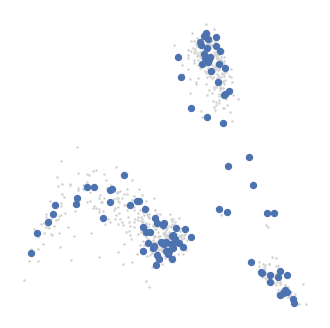

Randomly initialized A matrix.
Setting convergence threshold at 0.00037
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 37 iterations.
Ran for 38 iterations
Ran for 43 iterations


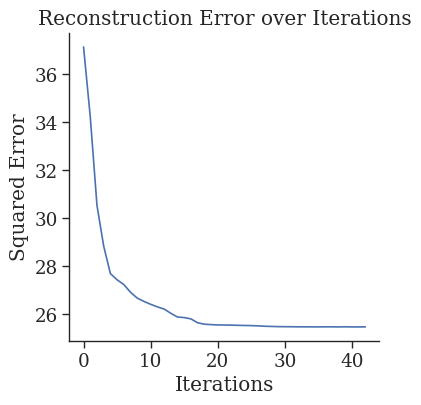

/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


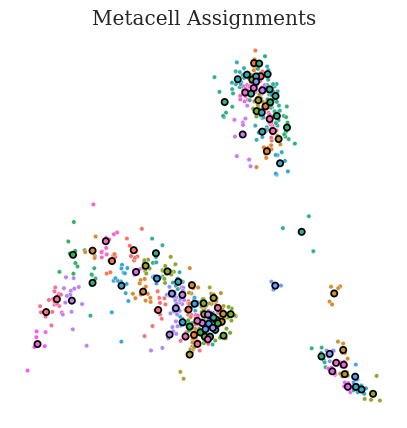

AnnData object with n_obs × n_vars = 800 × 2
    obs: 'SEACell'
    uns: 'neighbors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [10]:
## User defined parameters
## Core parameters 
n_SEACells_cells = 100
build_kernel_on = 'X_umap' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
RNA_struct_MOGP = SEACells_compute(RNA_struct_MOGP, n_SEACells_cells, build_kernel_on, n_waypoint_eigs)
RNA_struct_MOGP

In [ ]:
# We save the meta cells which are obtained.
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/'+'NumMetaCells='+str(n_SEACells_cells)+'seaCell_metaCells.csv' 
file = open(save_path,'wb')
pickle.dump(RNA_struct_MOGP.obs[['SEACell']],file)
file.close()

### genes

In [11]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/embs2.csv' 
file = open(save_path,'rb')
object_file = pickle.load(file)
file.close()

Genes_struct_MOGP = ad.AnnData(object_file)
Genes_struct_MOGP.obsm['X_umap']= object_file

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/800 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/800 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/800 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_umap
Computing diffusion components from X_umap for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 93 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1186.82it/s]

Selecting 7 cells from greedy initialization.


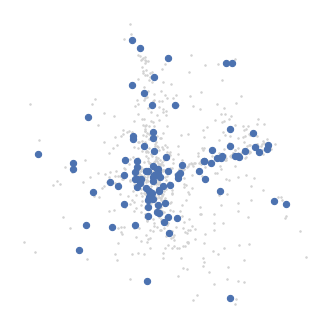

Randomly initialized A matrix.
Setting convergence threshold at 0.00037
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 32 iterations.
Ran for 33 iterations
Ran for 38 iterations


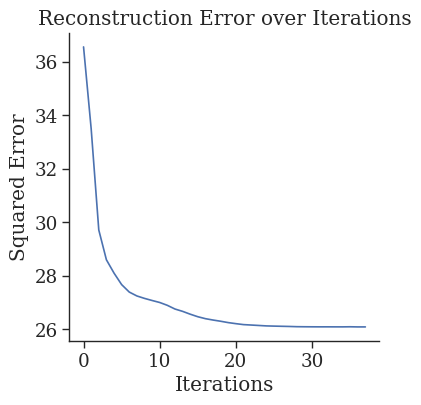

/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


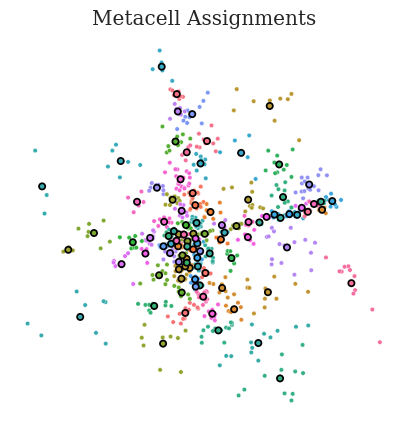

AnnData object with n_obs × n_vars = 800 × 2
    obs: 'SEACell'
    uns: 'neighbors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [12]:
## User defined parameters
## Core parameters 
n_SEACells_genes = 100
build_kernel_on = 'X_umap' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data
## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
Genes_struct_MOGP = SEACells_compute(Genes_struct_MOGP, n_SEACells_genes, build_kernel_on, n_waypoint_eigs)
Genes_struct_MOGP

In [ ]:
# We save the meta genes which are obtained.
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/'+'NumMetaCells='+str(n_SEACells_genes)+'seaCell_metaGenes.csv' 
file = open(save_path,'wb')
pickle.dump(Genes_struct_MOGP.obs[['SEACell']],file)
file.close()

## Gene Relevance Map
#### We will load the cell and gene embedding of the best result, associated with the 2D embedded MOGP with 200 epochs. Then, we load their meta-cells and meta-genes.
#### Its gene relevance map and meta gene relevance map are provided in subsequent steps. 

In [13]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/embs1.csv' 
file = open(save_path,'rb')
object_file = pickle.load(file)
file.close()

RNA_struct_MOGP = ad.AnnData(object_file)
RNA_struct_MOGP.obsm['X_umap']= object_file

In [14]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/embs2.csv' 
file = open(save_path,'rb')
object_file = pickle.load(file)
file.close()

Genes_struct_MOGP = ad.AnnData(object_file)
Genes_struct_MOGP.obsm['X_umap']= object_file

In [16]:
n_SEACells_cells=100
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/'+'NumMetaCells='+str(n_SEACells_cells)+'seaCell_metaCells.csv' 
file = open(save_path,'rb')
metaCells = pickle.load(file)
file.close()
RNA_struct_MOGP.obs[['SEACell']]=metaCells

n_SEACells_genes=100
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/'+'NumMetaCells='+str(n_SEACells_genes)+'seaCell_metaGenes.csv' 
file = open(save_path,'rb')
metaGenes = pickle.load(file)
file.close()
Genes_struct_MOGP.obs[['SEACell']]=metaGenes

/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: xlabel='0', ylabel='1'>

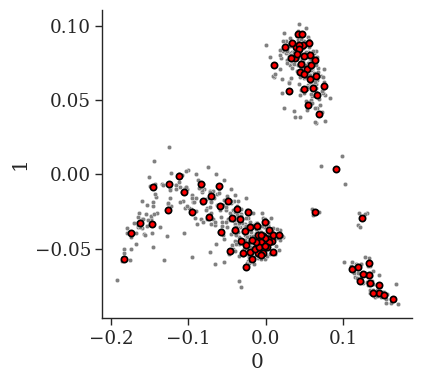

In [17]:
umap = pd.DataFrame(RNA_struct_MOGP.obsm['X_umap']).set_index(RNA_struct_MOGP.obs_names).join(RNA_struct_MOGP.obs['SEACell'])
umap['SEACell'] = umap['SEACell'].astype("category")
mcs_cells = umap.groupby('SEACell').mean().reset_index()
sns.scatterplot(x=0, y=1,
                        color='grey',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                color='red',
                data=mcs_cells,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: xlabel='0', ylabel='1'>

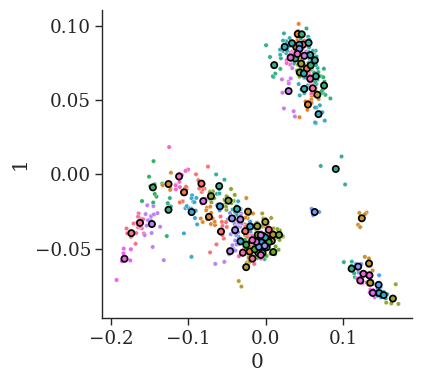

In [18]:
sns.scatterplot(x=0, y=1,
                        hue='SEACell',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                hue='SEACell',
                data=mcs_cells,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: xlabel='0', ylabel='1'>

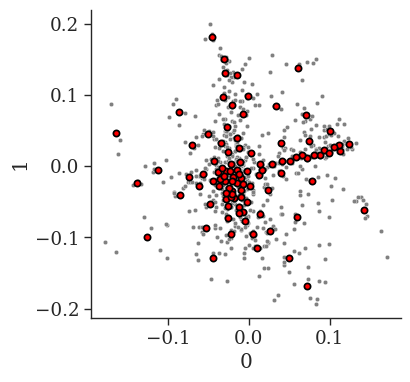

In [19]:
umap = pd.DataFrame(Genes_struct_MOGP.obsm['X_umap']).set_index(Genes_struct_MOGP.obs_names).join(Genes_struct_MOGP.obs['SEACell'])
umap['SEACell'] = umap['SEACell'].astype("category")
mcs_genes = umap.groupby('SEACell').mean().reset_index()
sns.scatterplot(x=0, y=1,
                        color='grey',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                color='red',
                data=mcs_genes,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: xlabel='0', ylabel='1'>

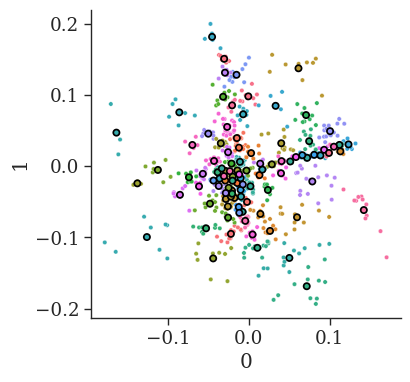

In [20]:
sns.scatterplot(x=0, y=1,
                        hue='SEACell',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                hue='SEACell',
                data=mcs_genes,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

In [21]:
RNA_struct_MOGP

AnnData object with n_obs × n_vars = 800 × 2
    obs: 'SEACell'
    obsm: 'X_umap'

In [22]:
Genes_struct_MOGP

AnnData object with n_obs × n_vars = 800 × 2
    obs: 'SEACell'
    obsm: 'X_umap'

#### The functions related to Gene Relevance MAP are defined based on the following paper: 
"Angerer, P., Fischer, D.S., Theis, F.J., Scialdone, A. and Marr, C., 2020. Automatic identification of relevant genes from low-dimensional embeddings of single-cell RNA-seq data. Bioinformatics, 36(15), pp.4291-4295."

In [23]:
n_neighbors=6
#The value of the rg_max parameter significantly impacts the results and requires careful tuning to achieve optimal performance.
rg_max=50
n_bins=100

In [24]:
rank_dhatgc = rank_dhatgc_score(RNA_struct_MOGP, Genes_struct_MOGP, RNA_Normalized_2000, n_neighbors)

(800, 800)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274

In [25]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/rank_dhatgc_GeneRelevance3.csv' 
file = open(save_path,'wb')
pickle.dump(rank_dhatgc,file)
file.close()

In [26]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
save_path = './RunningPBMC5KCITEseqRNA-GPFlux '+title+'/rank_dhatgc_GeneRelevance3.csv' 
file = open(save_path,'rb')
rank_dhatgc = pickle.load(file)
file.close()

#### Gene Relevance for some famous genes: this is done for testing the results

In [27]:
LR_gPsi, avg_Psi = LRgPsi_avgPsi_score(RNA_struct_MOGP, Genes_struct_MOGP, rank_dhatgc, rg_max)

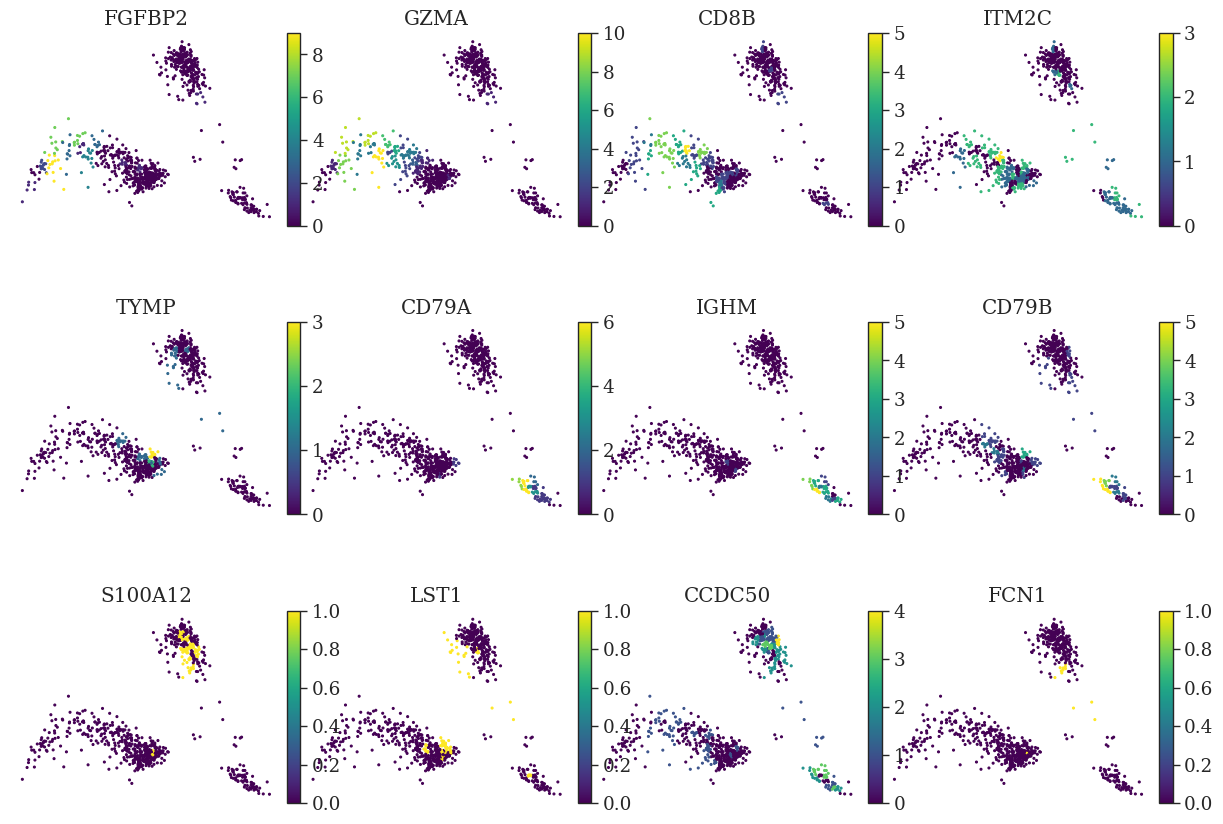

In [28]:
gene_list=['FGFBP2','GZMA','CD8B', 'ITM2C','TYMP', 'CD79A', 'IGHM','CD79B', "S100A12", 'LST1', 'CCDC50', 'FCN1' ]
Gene_Relevance_Map(rna_sampled, gene_list, LR_gPsi, avg_Psi)

#### Global Meta Gene Relevance: Instead of computing gene relevance, we compute the relevance of meta-genes to the cell embedding space. We then sort these meta-genes to compute the Global Meta Gene Relevance Map. For further information, please refer to the paper mentioned above.

In [29]:
rank_dhatMetagc = rank_dhatMetagc_score(RNA_struct_MOGP, Genes_struct_MOGP, rank_dhatgc)

In [30]:
LR_gPsi, avg_Psi, Global_idx = LRgPsi_avgPsi_GlobalMetascore(RNA_struct_MOGP, Genes_struct_MOGP, rank_dhatMetagc, rg_max)

In [31]:
mcs_genes_sorted0=mcs_genes[0].values[Global_idx]
mcs_genes_sorted1=mcs_genes[1].values[Global_idx]
mcs_genes_sorted_SEACell=mcs_genes['SEACell'].values[Global_idx]

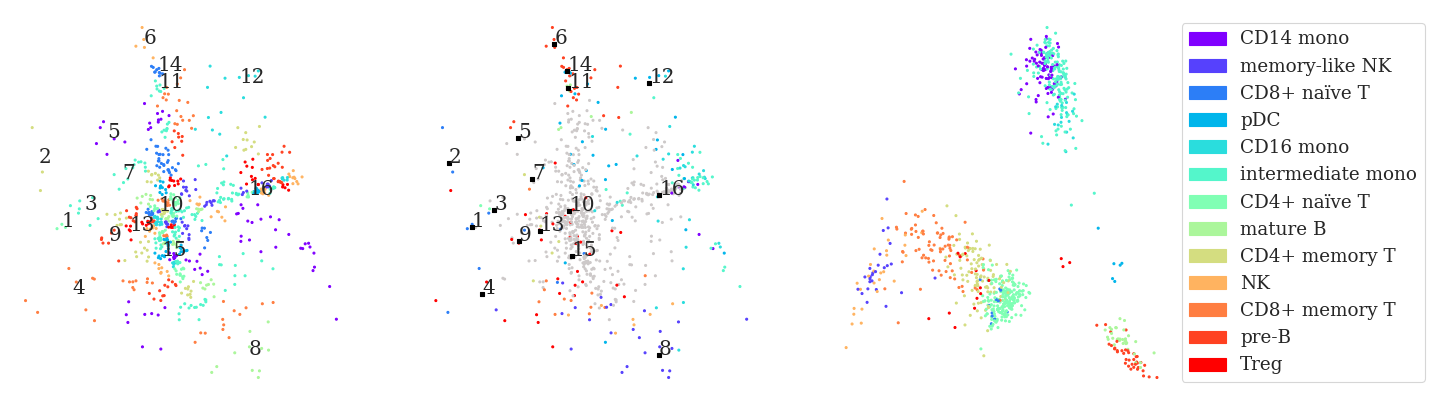

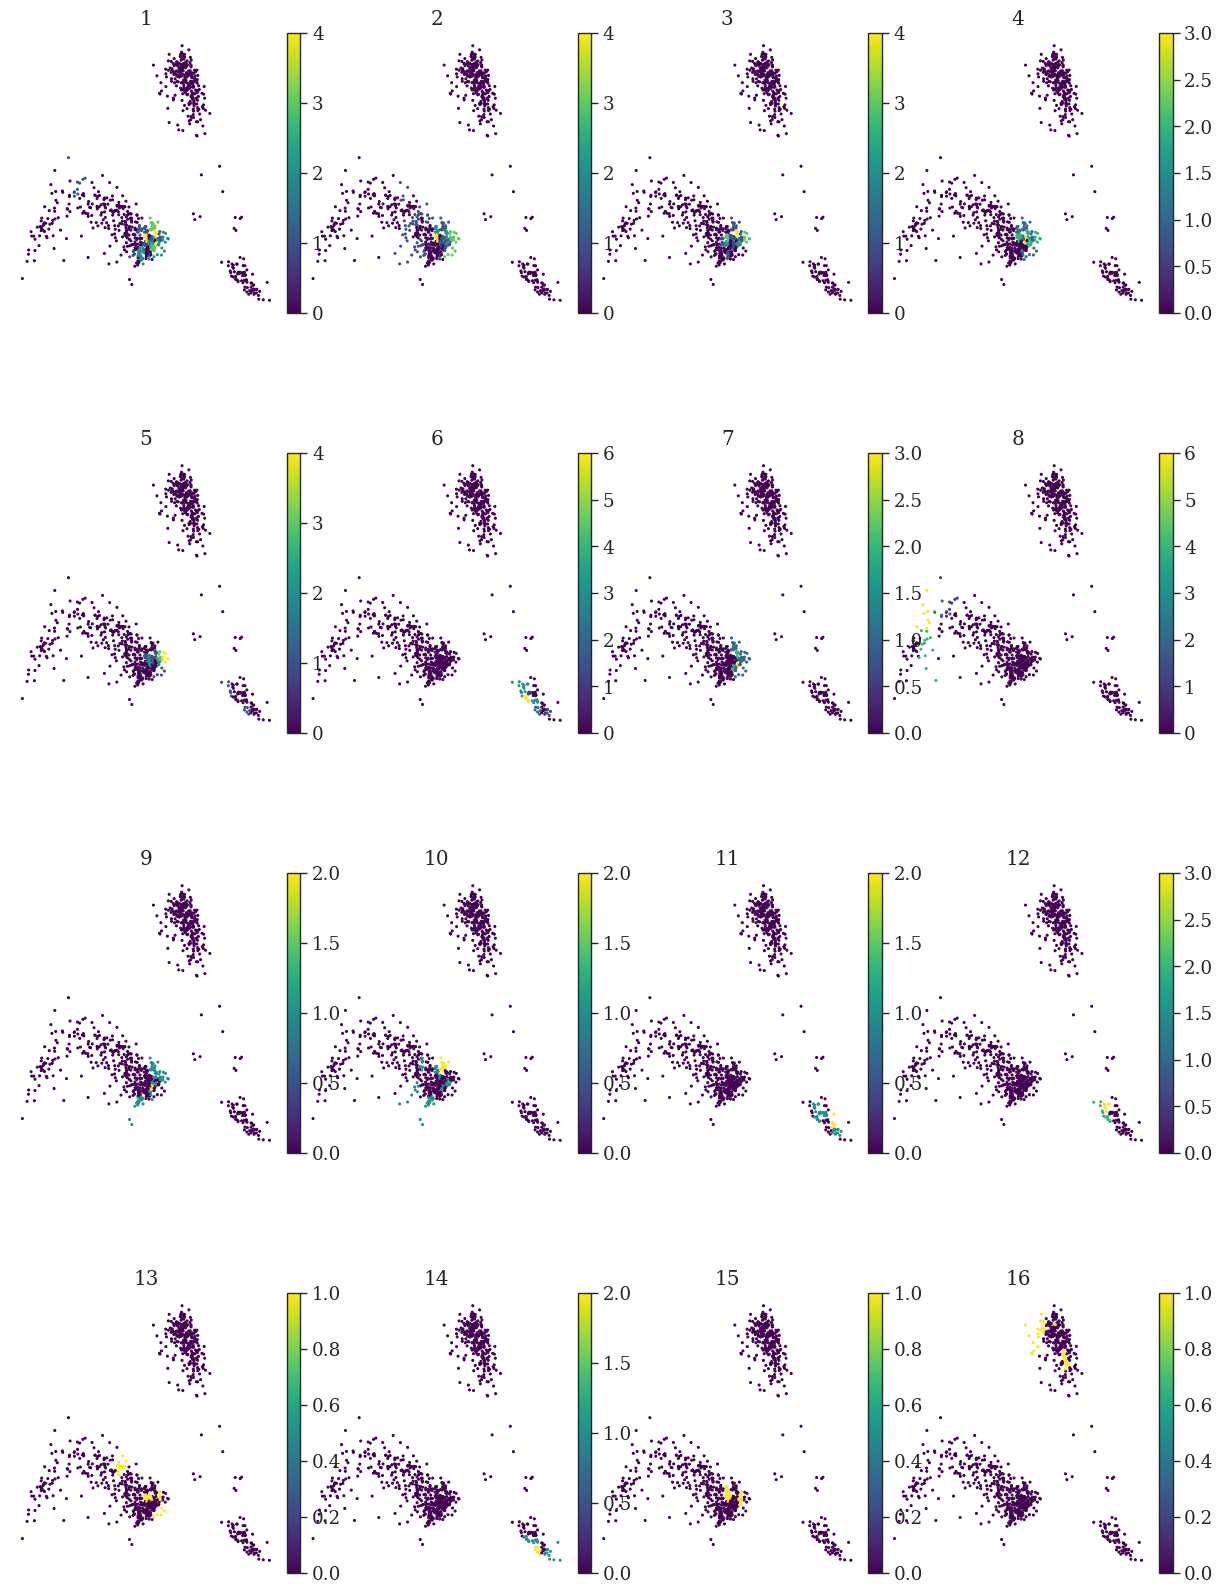

In [32]:
# The left plot uses colors assigned by the genes associated with each meta gene.
# The middle plot utilizes colors based on the cell type associated with each marker gene.
# The right plot displays cell embeddings colored by their respective cell types.
# Then we show meta gene relevance map for each mete gene.
Global_Gene_Relevance_Map_CITE(rna_sampled, RNA_struct_MOGP, Genes_struct_MOGP, col_dict1, mcs_genes_sorted0, mcs_genes_sorted1, mcs_genes_sorted_SEACell, LR_gPsi, avg_Psi, offset=0, topRG=16)

#### Merged_Meta_Genes: We will merge some of the meta-genes that are very close together in the gene embedding and have similar meta-gene relevance maps. We aim to retain those meta-genes that cover more cells in the cell embedding.

In [33]:
rank_dhatMetagc = rank_dhatMetagc_score(RNA_struct_MOGP, Genes_struct_MOGP, rank_dhatgc)

In [34]:
[cells,embs1_num]=RNA_struct_MOGP.obsm['X_umap'].shape
metaGenes=rank_dhatMetagc.shape[1]
GR_g=np.zeros(metaGenes)
for g in range(metaGenes):
    nom=np.sum([rank_dhatMetagc[:,g]<=np.repeat(rg_max, cells)])
    s = nom/cells
    GR_g[g]=s  
idx = GR_g.argsort()[-metaGenes:][::-1]
rank_dhatMetagc=rank_dhatMetagc[:,idx]

In [35]:
mcs_genes_sorted0=mcs_genes[0].values[idx]
mcs_genes_sorted1=mcs_genes[1].values[idx]
mcs_genes_sorted_SEACell=mcs_genes['SEACell'].values[idx]



In [36]:
metaGenesList_new=[[7],[0,1,2,3,4,6,8],[5,10,11,13],[15]]

In [37]:
mcs_genes_sorted0_new=[]
mcs_genes_sorted1_new=[]
mcs_genes_sorted_SEACell_new=[]
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[0]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[1]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[2]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[3]]))


mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[0]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[1]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[2]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[3]]))


mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[0]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[1]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[2]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[3]])

In [38]:
LR_gPsi, avg_Psi = LRgPsi_avgPsi_MergedMetascore(RNA_struct_MOGP, Genes_struct_MOGP, metaGenesList_new, rank_dhatMetagc, rg_max)

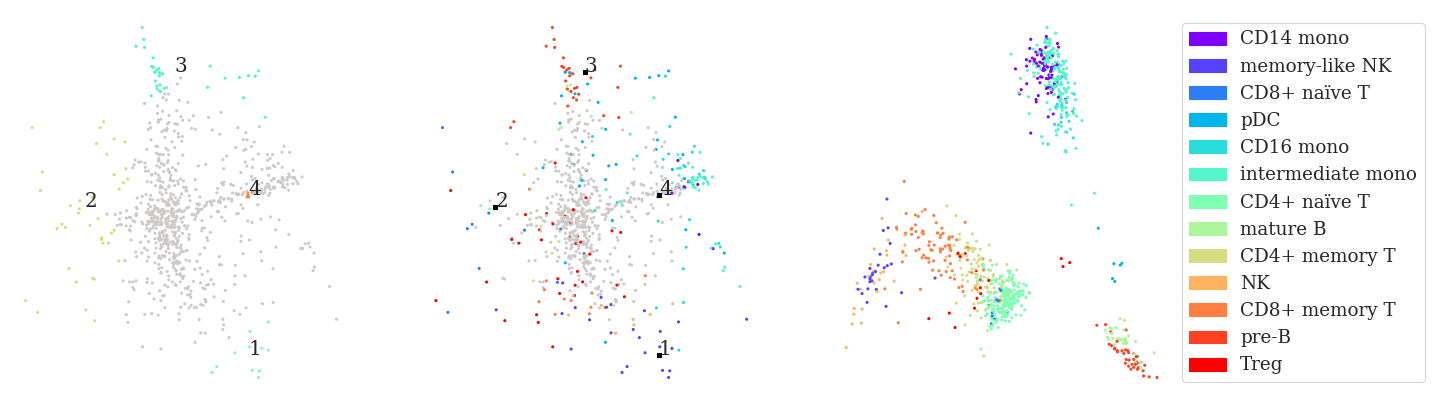

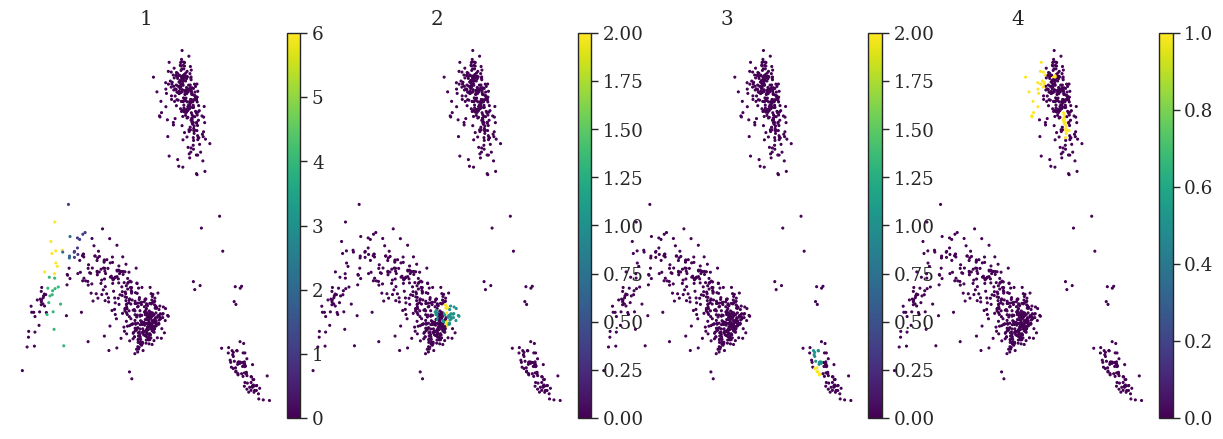

In [39]:
# The left plot uses colors assigned by the genes associated with each meta gene.
# The middle plot utilizes colors based on the cell type associated with each marker gene.
# The right plot displays cell embeddings colored by their respective cell types.
# Then we show meta gene relevance map for each mete gene.
Global_Gene_Relevance_Map_CITE(rna_sampled, RNA_struct_MOGP, Genes_struct_MOGP, col_dict1, mcs_genes_sorted0_new, mcs_genes_sorted1_new, mcs_genes_sorted_SEACell_new, LR_gPsi, avg_Psi, offset=0, topRG=4)